**Deep Kalman Filter example with Lorenz63: true model plus cubic model-error term and parameter mismatch, fully observable.**

Chinellato, E., Marcuzzi, F.: State, parameters and hidden dynamics estimation with
the deep kalman filter: regularization strategies. *Journal of Computational Science* **87**, 102569 (2025). https://doi.org/https://doi.org/10.1007/978-3-031-63775-9

In [1]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import scipy.io as sio
import pickle
import sys

DKFDirectory = '..'
sys.path.append(DKFDirectory)
import CreateTrainingSet_Lorenz63_4DKF

from DeepKalmanFilter.main import main
from DeepKalmanFilter.ConstructLaplacianMatrices import *
from DeepKalmanFilter.ConstructSGMatrices import *
from DeepKalmanFilter.ConstructTVMatrices import *
from DeepKalmanFilter.Utility import *
WorkingDirectory = './'

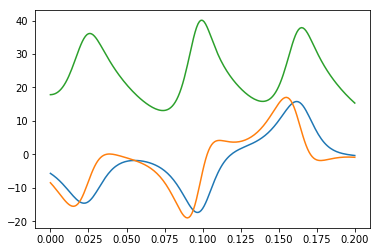

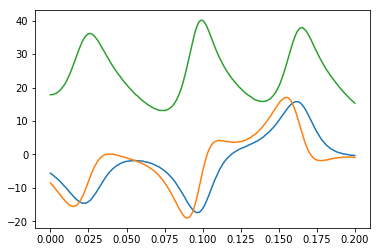

In [2]:
# dataset creation:
CreateTrainingSet_Lorenz63_4DKF.create(Experiment='L63_4')

In [3]:
TrainingBatchNum = 100 #300 #150 #1000
TrainingBatchSize = 1

# DKF parameters setting:
NetParameters = {}
### General parameters:
NetParameters['Experiment'] = sio.loadmat('Experiment.mat',squeeze_me = True)['Experiment']
NetParameters['Layers'] = sio.loadmat(f'LayersExp{NetParameters["Experiment"]}.mat',squeeze_me = True)['Layers']
NetParameters['Model'] = loadPickle(f'ModelExp{NetParameters["Experiment"]}.mat')
NetParameters['C'] = sio.loadmat(f'CExp{NetParameters["Experiment"]}.mat',squeeze_me = True)['C']
NetParameters['StateDimension'] = NetParameters['C'].shape[1]
NetParameters['ObservationDimension'] = NetParameters['C'].shape[0]
NetParameters['WeightMats'] = 'Input'  #Supported values: Input, Identity  
NetParameters['HiddenDynamicsNumber'] = 1
NetParameters['HiddenDynamicsDimension'] = [sio.loadmat(f'HiddenDynDimExp{NetParameters["Experiment"]}.mat',squeeze_me = True)['HiddenDynDim']]*NetParameters['HiddenDynamicsNumber']
NetParameters['ActivateModelDiscovery'] = 'Yes' #'No','Yes'
### Learning parameters:
NetParameters['SharedWeights'] = 'No' #'No','Yes'
NetParameters['BackPropagation'] = 'Complete' #'Complete','Truncated'                                           #Supported values: Complete, Truncated  
NetParameters['ProjectDynamics'] = 'No' #'No','Yes'
NetParameters['Jacobians'] = 'Approximated' #'Approximated', 'Algebraic'  
NetParameters['FiniteDifferences'] = 'Central' #'Supported values: 'Forward', 'Backward', 'Central'  
NetParameters['FiniteDifferencesSkip'] = 1e-9 
NetParameters['GainLearningRate'] = (1e-5) / TrainingBatchSize
NetParameters['GainLearningRateReduction'] = 1
NetParameters['GainLearningRateIncrease'] = 1e2
NetParameters['DynamicsLearningRate'] = (1.8e-2) / TrainingBatchSize
NetParameters['DynamicsLearningRateReduction'] = 0.2
### Loss function parameters:
Pen1Val = 1e0
Pen2Val = np.ones(NetParameters['Layers']) * 1e0
NormPen = max(Pen1Val, Pen2Val.max())
NetParameters['Penalty0'] = 1.e6
NetParameters['Penalty1'] = np.ones(NetParameters['Layers']) * Pen1Val / NormPen
NetParameters['Penalty2'] = Pen2Val / NormPen
NetParameters['Penalty3'] = 1.e0 / (NetParameters['StateDimension'] * NetParameters['ObservationDimension'])
NetParameters['Penalty4'] = 0.01 #0.2 # soft-thresholding
NetParameters['L'], NetParameters['LtL'] = ConstructLaplacianMatrices( NetParameters['Layers'], NetParameters['Model']['SamplingTimes'] )
### Adam (learning optimizer) parameters:
NetParameters['Optimizer'] = 'Adam'
NetParameters['BetaMoment1'] = 0.9
NetParameters['BetaMoment2'] = 0.999
NetParameters['Initialization'] = 'Deterministic'   #'Random', 'Deterministic', 'DeterministcComplete'  
NetParameters['InitializationMean'] = 0
NetParameters['InitializationSigma'] = 0.0001
NetParameters['AdamEpsilon'] = 1e-16
### Learning stop condition parameters:
NetParameters['TrainingConditionStop'] = 'Residues' #'Whiteness', 'Residues'  
NetParameters['ResidueDecreaseThreshold'] = 1e-3
NetParameters['ActivateWhitenessMask'] = 'Yes'
NetParameters['WhitenessLagCounter'] = 1
NetParameters['WhitenessIterationCheck'] = 20
NetParameters['WhitenessUpdateCheck'] = 8
NetParameters['WhitenessDecreaseThreshold'] = -1e-3
### Model discovery parameters:
NetParameters['DictionaryBlocks'] = ['Constant', 'Linear', 'Quadratic', 'Cubic']
NetParameters['AllowedDictionaryBlocks'] = {
    'Constant': 1,
    'Linear': NetParameters['StateDimension'],
    'Quadratic': NetParameters['StateDimension'] * (NetParameters['StateDimension'] + 1) // 2,
    'Cubic': NetParameters['StateDimension'] * (NetParameters['StateDimension'] + 1) * (NetParameters['StateDimension'] + 2) // 6
}
NetParameters['DictionaryDimension'] = sum(NetParameters['AllowedDictionaryBlocks'][block] for block in NetParameters['DictionaryBlocks'])
NetParameters['ModelDiscoveryForceCheck'] = 1000
NetParameters['ModelDiscoveryUpdateBoth'] = 'Yes'
NetParameters['ModelDiscoveryMethod'] = 'OMP'                                            #Supported values: OMP, LH  
NetParameters['ModelDiscoverySmoothing'] = 'SGMixed2'                                    #Supported values: TV, TVMixed, SG, SGMixed1, SGMixed2
NetParameters['ModelDiscoveryFirstState'] = min(0, NetParameters['Layers'] // 2)
NetParameters['A'], NetParameters['D'], NetParameters['AtA'], NetParameters['B'] = ConstructTVMatrices( NetParameters['Layers'] - NetParameters['ModelDiscoveryFirstState'], NetParameters['Model']['SamplingTimes'] )
NetParameters['WinLen'] = 31
NetParameters['StencilA0'], NetParameters['StencilA1'] = ConstructSGMatrices(NetParameters['WinLen'])
NetParameters['ModelDiscoveryRelativeThreshold'] = 0.8
NetParameters['ModelDiscoveryStblSuppCondition'] = 4
NetParameters['ModelDiscoveryStblSuppUpdates'] = 1
NetParameters['OMPSparsity'] = 1

# Save net parameters
sio.savemat('DefaultNetParameters.mat', {'NetParameters': NetParameters})

/Users/marcuzzi/opt/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/io/matlab/miobase.py:414: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  arr[empties] = ' '


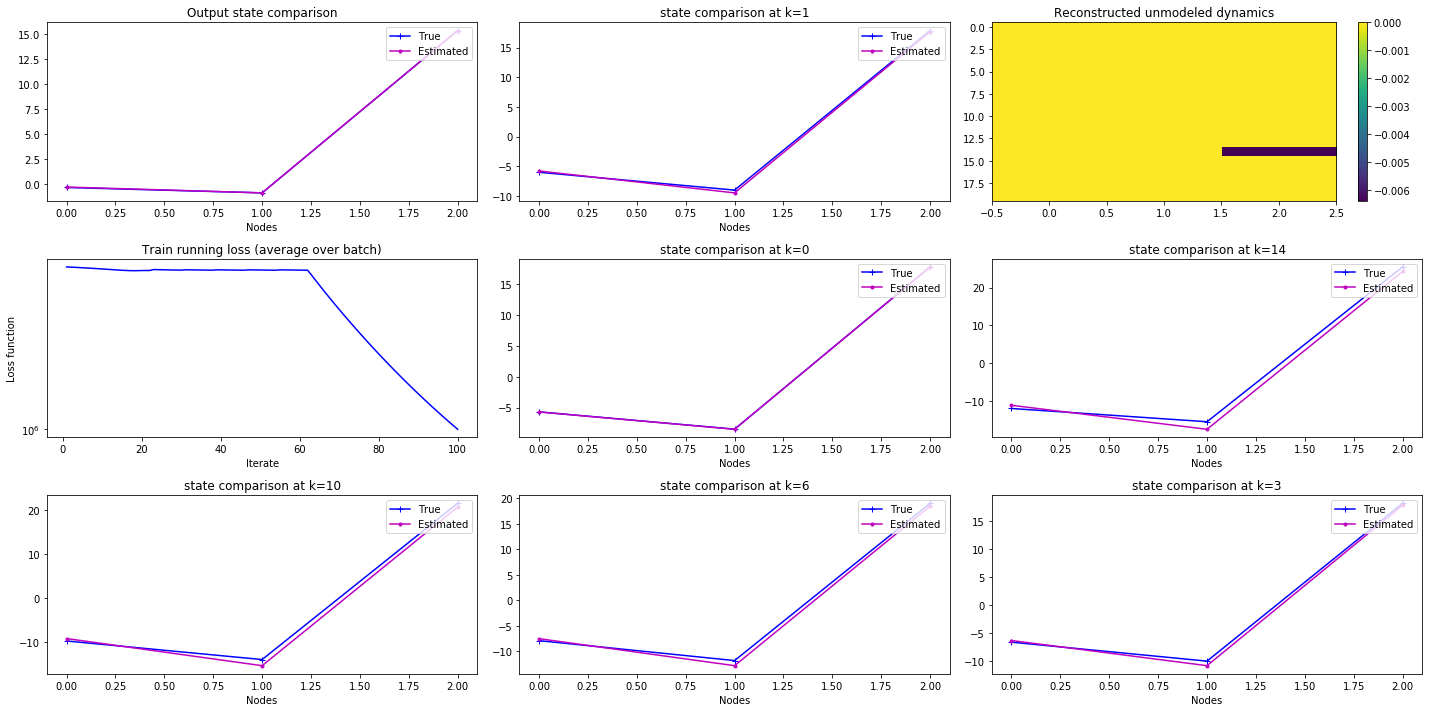

********************************************************************************
Training completed.
Updated weights for the net have been saved and are ready to be used.
********************************************************************************



In [4]:
main(WorkingDirectory,NetParameters,TrainingBatchSize,TrainingBatchNum)